In [23]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score as sklearn_f1_score, jaccard_score

In [24]:
# Load the lung images and masks from the dataset

image_dir = r"/mnt/c/Users/prathana/Desktop/k-mam-seg/lung/images"
mask_dir = r"/mnt/c/Users/prathana/Desktop/k-mam-seg/lung/masks"

# Function to load images and masks

def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    
    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        img = cv2.resize(img, img_size)
        mask = cv2.resize(mask, img_size)
        
        # Convert single channel grayscale image to 3 channels
        img = np.stack((img,)*3, axis=-1)
        
        mask = np.expand_dims(mask, axis=-1)
        
        images.append(img)
        masks.append(mask)
    
    images = np.array(images)
    masks = np.array(masks)
    
    return images, masks

images, masks = load_data(image_dir, mask_dir)


In [25]:
# Normalize images and masks

images = images / 255.0
masks = masks / 255.0

In [26]:
# Train-test split the dataset into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [27]:
# Define a VGG-based U-Net Model for lung segmentation

def vgg_unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    vgg_base = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

    # Encoder
    s1 = vgg_base.get_layer('block1_conv2').output         # 128x128x64
    s2 = vgg_base.get_layer('block2_conv2').output         # 64x64x128
    s3 = vgg_base.get_layer('block3_conv3').output         # 32x32x256
    s4 = vgg_base.get_layer('block4_conv3').output         # 16x16x512

    bridge = vgg_base.get_layer('block5_conv3').output     # 8x8x512

    # Decoder
    d1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)  # 16x16x512
    d1 = concatenate([d1, s4])
    d1 = Conv2D(512, (3, 3), activation='relu', padding='same')(d1)
    d1 = Conv2D(512, (3, 3), activation='relu', padding='same')(d1)

    d2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(d1)  # 32x32x256
    d2 = concatenate([d2, s3])
    d2 = Conv2D(256, (3, 3), activation='relu', padding='same')(d2)
    d2 = Conv2D(256, (3, 3), activation='relu', padding='same')(d2)

    d3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d2)  # 64x64x128
    d3 = concatenate([d3, s2])
    d3 = Conv2D(128, (3, 3), activation='relu', padding='same')(d3)
    d3 = Conv2D(128, (3, 3), activation='relu', padding='same')(d3)

    d4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d3)  # 128x128x64
    d4 = concatenate([d4, s1])
    d4 = Conv2D(64, (3, 3), activation='relu', padding='same')(d4)
    d4 = Conv2D(64, (3, 3), activation='relu', padding='same')(d4)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs, outputs)
    return model

model = vgg_unet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 25,854,657 (98.63 MB)

 Trainable params: 25,854,657 (98.63 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Define custom metric functions for evaluating the model performance

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def jaccard_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + K.epsilon())

model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', dice_coefficient, precision, recall, f1_score, jaccard_index])

In [29]:
# Train the  VGG-based U-Net model

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 36s 148ms/step - accuracy: 0.8030 - dice_coefficient: 0.4579 - f1_score: 0.4236 - jaccard_index: 0.3177 - loss: 0.4963 - precision: 0.5046 - recall: 0.4034 - val_accuracy: 0.9320 - val_dice_coefficient: 0.8116 - val_f1_score: 0.8586 - val_jaccard_index: 0.6834 - val_loss: 0.1648 - val_precision: 0.9086 - val_recall: 0.8148
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.9482 - dice_coefficient: 0.8652 - f1_score: 0.8938 - jaccard_index: 0.7648 - loss: 0.1190 - precision: 0.9210 - recall: 0.8710 - val_accuracy: 0.9692 - val_dice_coefficient: 0.9301 - val_f1_score: 0.9391 - val_jaccard_index: 0.8697 - val_loss: 0.0603 - val_precision: 0.9613 - val_recall: 0.9182
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - accuracy: 0.9708 - dice_coefficient: 0.9359 - f1_score: 0.9402 - jaccard_index: 0.8798 - loss: 0.0549 - precision: 0.9539 - recall: 0.9275 - val_accuracy: 0.9727 - val_dice_coefficient: 0.9433 - val_f1_score: 0.94

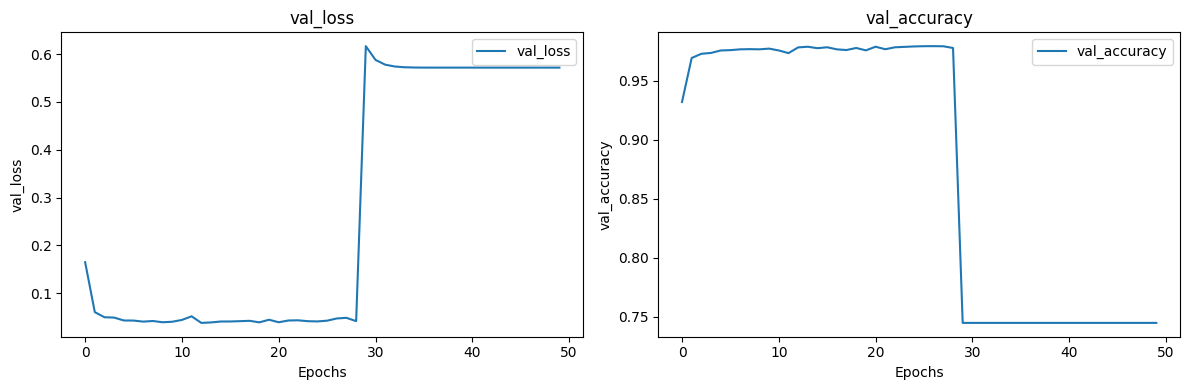

In [30]:
# Plot the validation accuracy and validation loss

def plot_val_metrics(history):
    metrics = ['val_loss', 'val_accuracy']
    plt.figure(figsize=(12, 4))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i + 1)
        plt.plot(history.history[metric], label=metric)
        plt.title(metric)
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_val_metrics(history)

In [31]:
# Predict on validation data

preds = model.predict(X_val)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


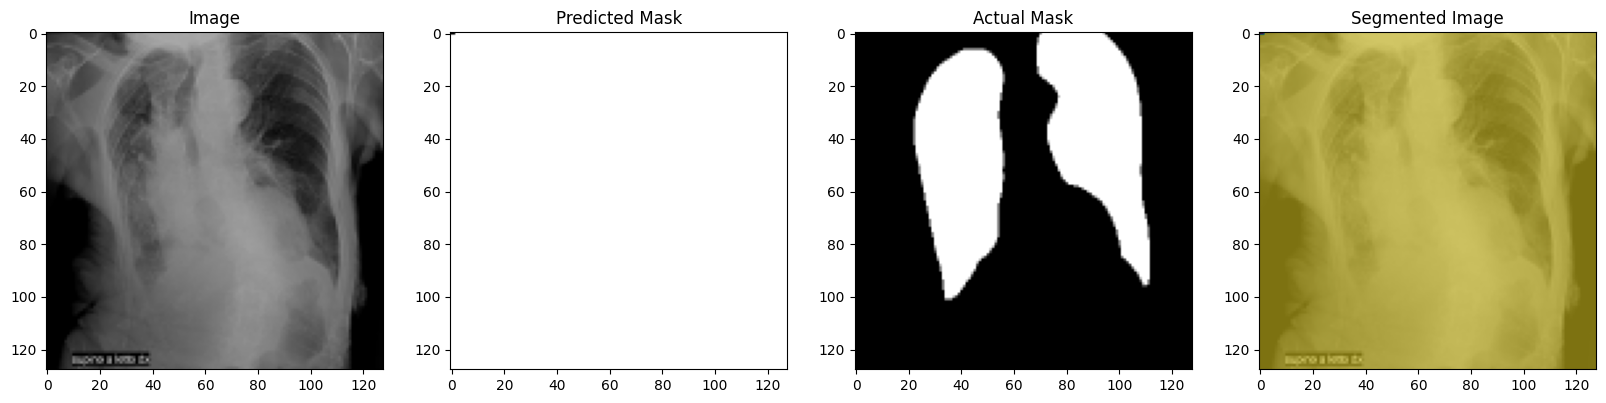

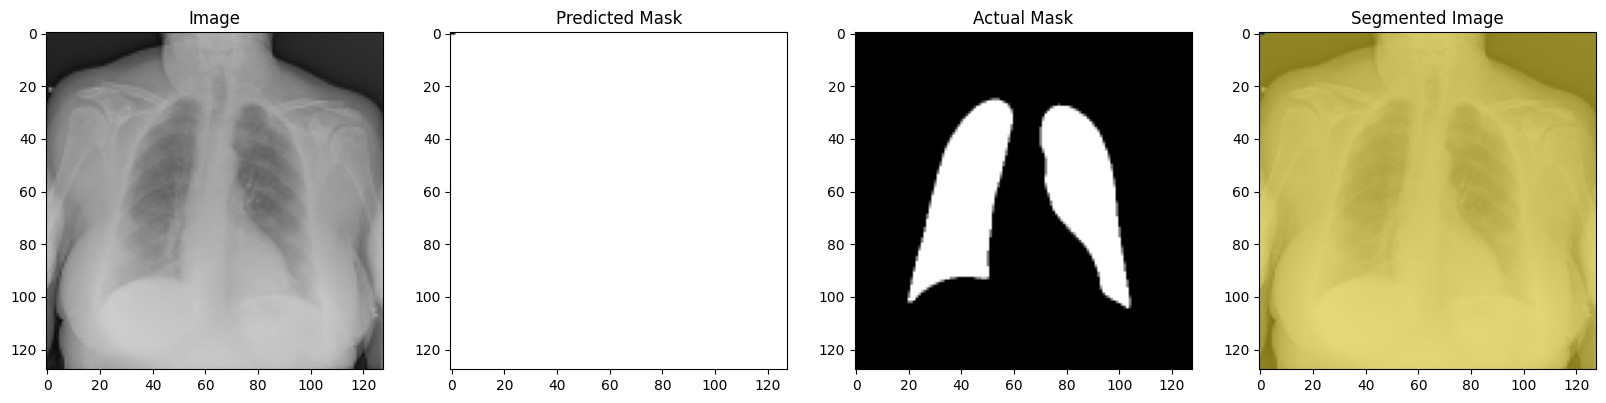

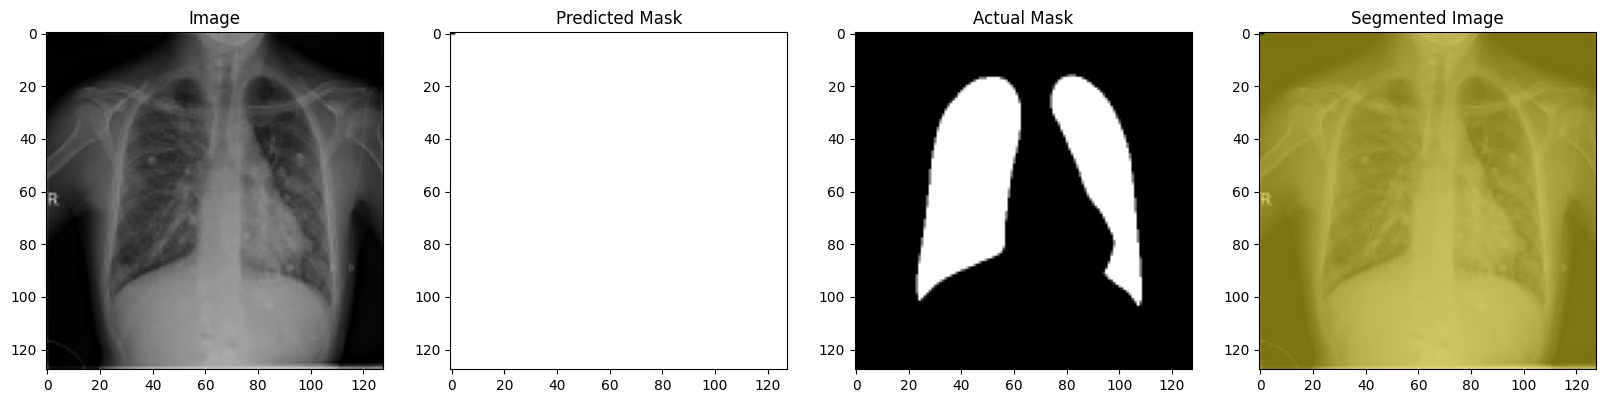

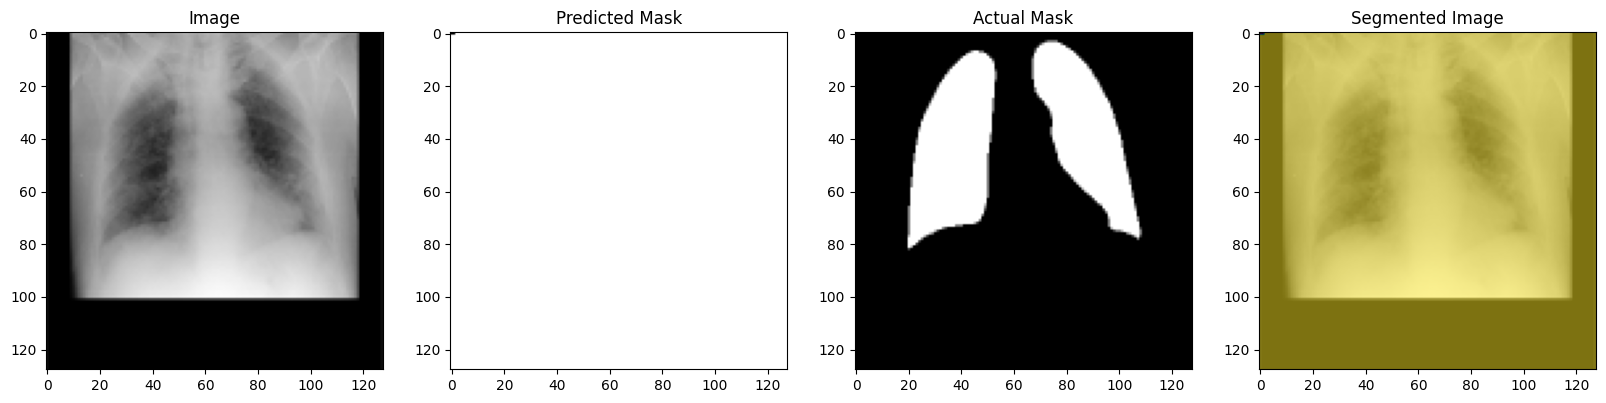

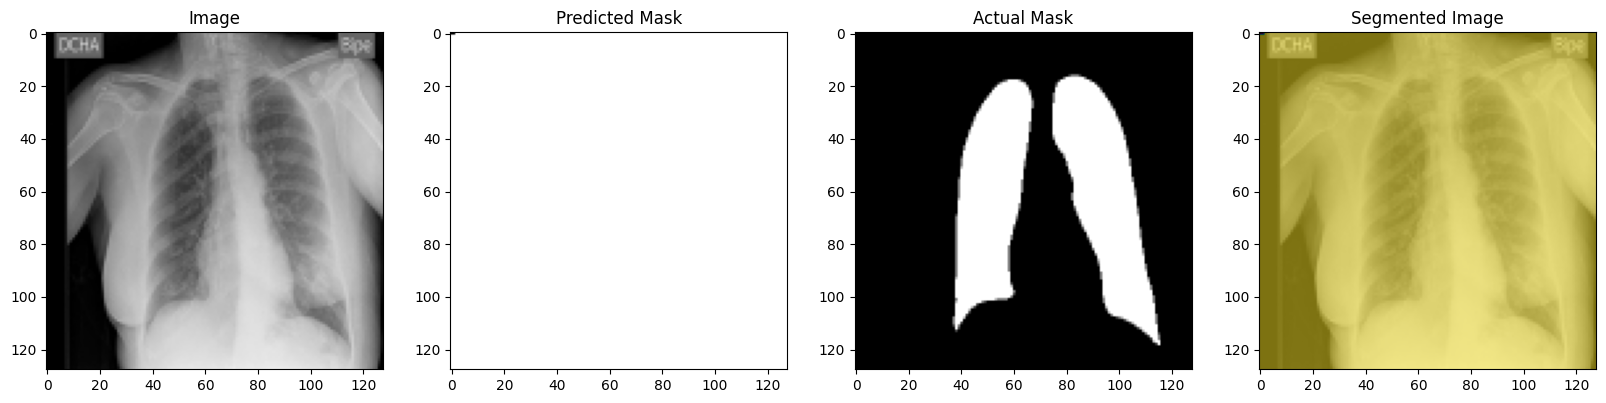

In [32]:
# Visualize the results

def plot_sample(image, mask, pred_mask):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(image.squeeze(), cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(pred_mask.squeeze(), cmap='gray')
    axs[1].set_title('Predicted Mask')
    axs[2].imshow(mask.squeeze(), cmap='gray')
    axs[2].set_title('Actual Mask')
    axs[3].imshow(image.squeeze(), cmap='gray')
    axs[3].imshow(pred_mask.squeeze(), alpha=0.5)
    axs[3].set_title('Segmented Image')
    plt.show()

# Display a few samples

for i in range(5):
    plot_sample(X_val[i], y_val[i], preds[i])

In [33]:
# Ensure y_val contains binary values

y_val_binary = (y_val > 0.5).astype(int)

# Ensure preds are binary values based on your threshold (0.5)

preds_binary = (preds > 0.5).astype(int)

# Flatten the arrays for metric calculation

y_val_flat = y_val_binary.flatten()
preds_flat = preds_binary.flatten()

# Calculate metrics

val_accuracy = accuracy_score(y_val_flat, preds_flat)
val_precision = precision_score(y_val_flat, preds_flat)
val_recall = recall_score(y_val_flat, preds_flat)
val_f1_score = sklearn_f1_score(y_val_flat, preds_flat)
val_jaccard_index = jaccard_score(y_val_flat, preds_flat)

# Dice coefficient is often computed using the F1 score for binary classification problems

val_dice_coefficient = 2 * (val_precision * val_recall) / (val_precision + val_recall)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1_score:.4f}")
print(f"Validation Jaccard Index: {val_jaccard_index:.4f}")
print(f"Validation Dice Coefficient: {val_dice_coefficient:.4f}")


/home/lassya/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.7492
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1 Score: 0.0000
Validation Jaccard Index: 0.0000
Validation Dice Coefficient: nan


/tmp/ipykernel_829474/2999384532.py:24: RuntimeWarning: invalid value encountered in scalar divide
  val_dice_coefficient = 2 * (val_precision * val_recall) / (val_precision + val_recall)


In [34]:
# Displaying all the metrics in percentage

val_accuracy_percent = val_accuracy * 100
val_precision_percent = val_precision * 100
val_recall_percent = val_recall * 100
val_f1_score_percent = val_f1_score * 100
val_jaccard_index_percent = val_jaccard_index * 100
val_dice_coefficient_percent = val_dice_coefficient * 100

print(f"Validation Accuracy: {val_accuracy_percent:.2f} %")
print(f"Validation Precision: {val_precision_percent:.2f} %")
print(f"Validation Recall: {val_recall_percent:.2f}%")
print(f"Validation F1 Score: {val_f1_score_percent:.2f} %")
print(f"Validation Jaccard Index: {val_jaccard_index_percent:.2f} %")
print(f"Validation Dice Coefficient: {val_dice_coefficient_percent:.2f} %")

Validation Accuracy: 74.92 %
Validation Precision: 0.00 %
Validation Recall: 0.00%
Validation F1 Score: 0.00 %
Validation Jaccard Index: 0.00 %
Validation Dice Coefficient: nan %
